## Дипломная работа

### Прогнозирование продаж фармдистрибьютора

In [1]:
# необходимые библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from arch import arch_model

In [2]:
# данные в тыс руб.
df = pd.read_excel("Data.xls")
df.head()

,date,value
0,2019-01-03,515757.63689
1,2019-01-04,513952.19998
2,2019-01-05,3552.93217
3,2019-01-06,26971.21157
4,2019-01-07,0.00000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    910 non-null    datetime64[ns]
 1   value   910 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


In [4]:
# преобразуем и посмотрим статистику 

In [5]:
df.value = round(df.value)
df.value = df.value.astype(np.int32)

In [6]:
df.describe()

,value
count,9.100000e+02
mean,6.506428e+05
std,4.115450e+05
min,0.000000e+00
25%,2.267648e+05
50%,7.358910e+05
75%,9.629105e+05
max,1.661629e+06


In [7]:
# дополнительные функции

In [8]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return

In [9]:
# посмотрим на тест Дики-Фуллера и графики

Results of Dickey-Fuller Test:
Test Statistic                  -3.967059
p-value                          0.001593
Lags Used                       20.000000
Number of Observations Used    889.000000
Critical Value (1%)             -3.437727
Critical Value (5%)             -2.864797
Critical Value (10%)            -2.568504
dtype: float64


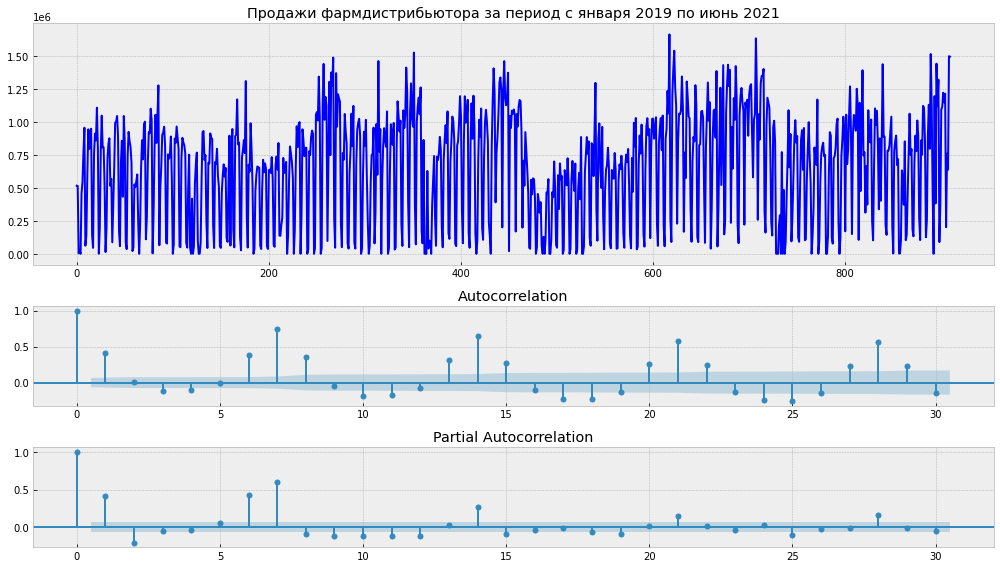

In [10]:
series = df.value
tsplot(series, title="Продажи фармдистрибьютора за период с января 2019 по июнь 2021")

In [11]:
# p-value отвергает гипотезу о нестационарности ряда. Ряд стационарен
# На графике нет тренда и цикличности, но есть сезонность. 

# Если бы была сильная дисперсия мы бы нормализовали ее при помощи преобразования Бокса-Кокса, например  boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -21.030822
p-value                          0.000000
Lags Used                       21.000000
Number of Observations Used    881.000000
Critical Value (1%)             -3.437794
Critical Value (5%)             -2.864826
Critical Value (10%)            -2.568520
dtype: float64


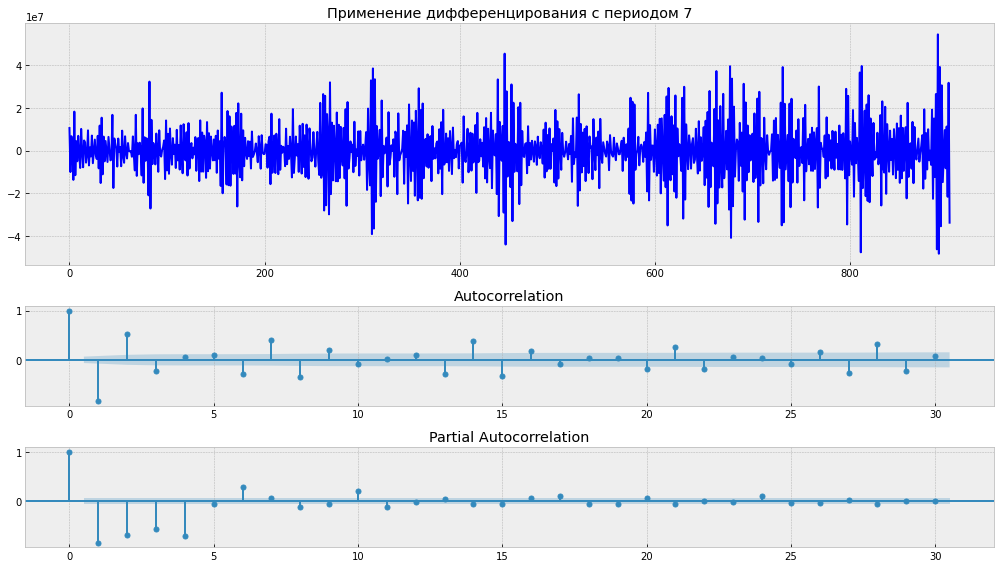

In [12]:
# Можно убрать сезонность дифференцированием
series = np.diff(series, 7)
tsplot(series, title="Применение дифференцирования с периодом 7")

Results of Dickey-Fuller Test:
Test Statistic                 -28.722483
p-value                          0.000000
Lags Used                        1.000000
Number of Observations Used    894.000000
Critical Value (1%)             -3.437686
Critical Value (5%)             -2.864778
Critical Value (10%)            -2.568494
dtype: float64


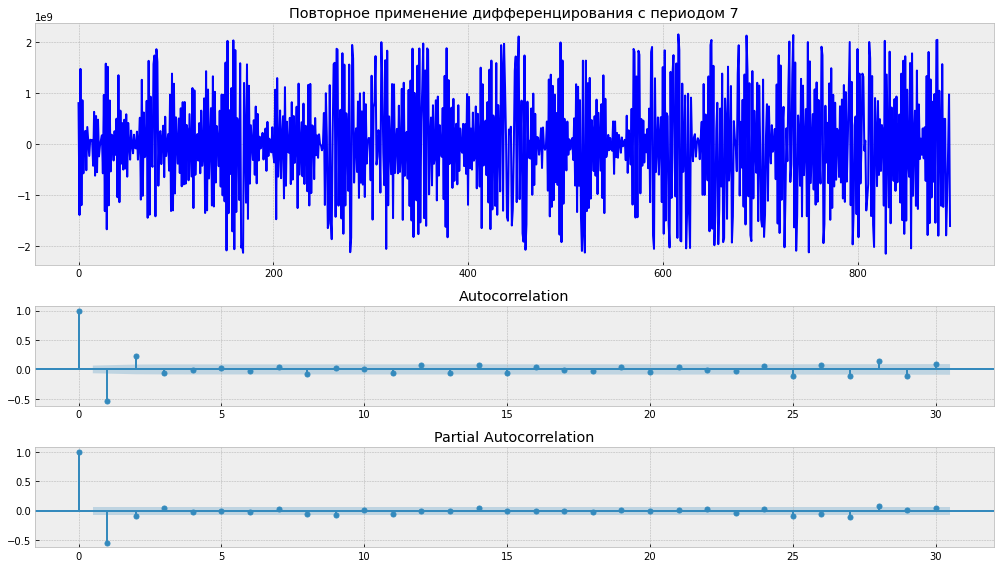

In [13]:
series = np.diff(series, 7)
tsplot(series, title="Повторное применение дифференцирования с периодом 7")

In [14]:
# для моделей не требуется предобработка данных, поэтому возьмем первоначальный ряд
series = df.value

In [15]:
# SARIMAX

In [16]:
# разделим на тренировочные и тестовые данные
len(series)

910

In [17]:
train_series = series[:880]
test_series = series[880:]

In [18]:
len(test_series)

30

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [20]:
# подберем наилучшие параметры для модели. На графике видно, что период сезонности равен 7, этот параметр подбирать не будем

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [22]:
best_aic = np.inf 
best_order = None
best_seasonal = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(series,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            tmp_aic = results.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = param
                best_seasonal = param_seasonal

        except: 
            continue
            
print('SARIMAX{}x{}7 - AIC:{}'.format(best_order,param_seasonal,best_aic))

SARIMAX(1, 0, 1)x(1, 1, 1, 7)7 - AIC:24709.418683249623


In [23]:
# подставим в модель найденные параметры, обучим на тренировочной выборке

In [24]:
mod = SARIMAX(train_series,
            order=(1, 0, 1),
            seasonal_order=(1, 1, 1, 7),
            enforce_stationarity=True,
            enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9372      0.028     33.063      0.000       0.882       0.993
ma.L1         -0.7220      0.049    -14.708      0.000      -0.818      -0.626
ar.S.L7        0.2086      0.048      4.367      0.000       0.115       0.302
ma.S.L7       -0.9680      0.019    -50.387      0.000      -1.006      -0.930
sigma2      7.859e+10   4.28e-14   1.84e+24      0.000    7.86e+10    7.86e+10


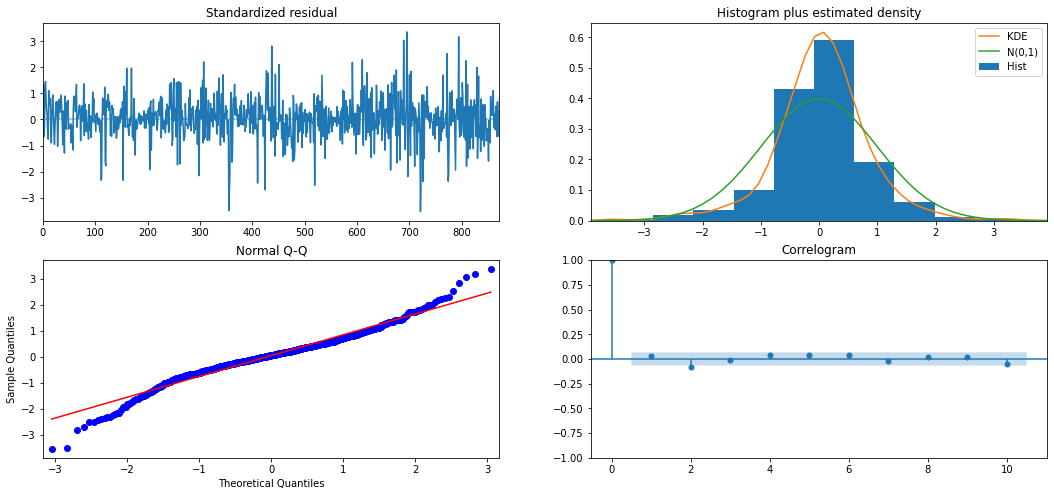

In [25]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [26]:
# предсказываем 30 значений
pred = results.forecast(steps=30)

In [27]:
# посчитаем метрики качества предсказания
print(f'RMSE: {(np.sqrt(mean_squared_error(test_series, pred))):.0f}')

RMSE: 322507


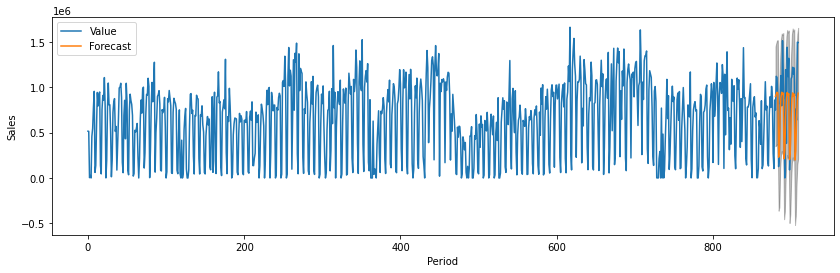

In [28]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = series.plot(label='Value', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Period')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [29]:
# LSTM

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [31]:
dataset = pd.read_excel("Data.xls", usecols=[1])

In [32]:
# нормализуем данные с помощью функции MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [33]:
# разделим данные на тестовые и тренинровочные
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Тренировочная выборка:',len(train), 'Тестовая выборка:', len(test))

Тренировочная выборка: 728 Тестовая выборка: 182


In [34]:
# преобразуем массив значений в матрицу данных 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [35]:
# изменим X=t и Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [36]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [37]:
# создадим и обучим модель LSTM. Вариант 1.

In [38]:
%%time
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
726/726 - 1s - loss: 0.0749
Epoch 2/100
726/726 - 0s - loss: 0.0522
Epoch 3/100
726/726 - 0s - loss: 0.0514
Epoch 4/100
726/726 - 0s - loss: 0.0509
Epoch 5/100
726/726 - 0s - loss: 0.0510
Epoch 6/100
726/726 - 0s - loss: 0.0508
Epoch 7/100
726/726 - 0s - loss: 0.0509
Epoch 8/100
726/726 - 0s - loss: 0.0507
Epoch 9/100
726/726 - 0s - loss: 0.0509
Epoch 10/100
726/726 - 0s - loss: 0.0509
Epoch 11/100
726/726 - 0s - loss: 0.0507
Epoch 12/100
726/726 - 0s - loss: 0.0508
Epoch 13/100
726/726 - 0s - loss: 0.0509
Epoch 14/100
726/726 - 0s - loss: 0.0507
Epoch 15/100
726/726 - 0s - loss: 0.0509
Epoch 16/100
726/726 - 0s - loss: 0.0507
Epoch 17/100
726/726 - 0s - loss: 0.0509
Epoch 18/100
726/726 - 0s - loss: 0.0505
Epoch 19/100
726/726 - 0s - loss: 0.0507
Epoch 20/100
726/726 - 0s - loss: 0.0508
Epoch 21/100
726/726 - 0s - loss: 0.0508
Epoch 22/100
726/726 - 0s - loss: 0.0508
Epoch 23/100
726/726 - 0s - loss: 0.0508
Epoch 24/100
726/726 - 0s - loss: 0.0508
Epoch 25/100
726/726 - 0s

In [39]:
# предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# инвертируем предсказания
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
# посчитаем метрику качества
trainScore = np.sqrt(mean_squared_error(scaler.inverse_transform([trainY])[0], trainPredict[:,0]))
print('Train Score v1: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], testPredict[:,0]))
print('Test Score v1: %.2f RMSE' % (testScore))

Train Score v1: 375377.02 RMSE
Test Score v1: 379582.07 RMSE


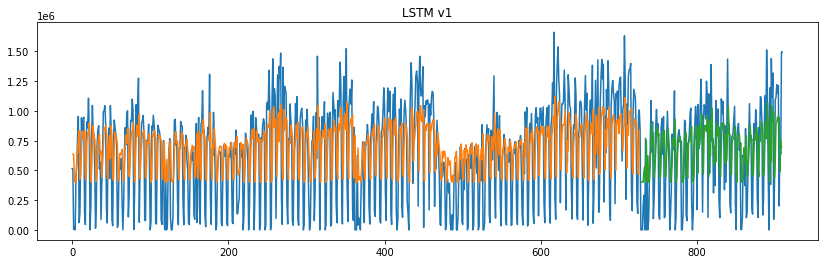

In [40]:
# покажем на графике полученные результаты. Вариант 1
plt.figure(figsize=(14, 4))
 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('LSTM v1')
plt.show()

In [41]:
# создадим и обучим модель LSTM. Вариант 2. Добавим эпох, увеличим батчи, добавим слои

In [42]:
%%time
model = Sequential()
model.add(LSTM(128,  return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=8, verbose=2)

Epoch 1/1000
91/91 - 2s - loss: 0.0843
Epoch 2/1000
91/91 - 0s - loss: 0.0520
Epoch 3/1000
91/91 - 0s - loss: 0.0508
Epoch 4/1000
91/91 - 0s - loss: 0.0511
Epoch 5/1000
91/91 - 0s - loss: 0.0516
Epoch 6/1000
91/91 - 0s - loss: 0.0508
Epoch 7/1000
91/91 - 0s - loss: 0.0506
Epoch 8/1000
91/91 - 0s - loss: 0.0509
Epoch 9/1000
91/91 - 0s - loss: 0.0512
Epoch 10/1000
91/91 - 0s - loss: 0.0509
Epoch 11/1000
91/91 - 0s - loss: 0.0508
Epoch 12/1000
91/91 - 0s - loss: 0.0510
Epoch 13/1000
91/91 - 0s - loss: 0.0512
Epoch 14/1000
91/91 - 0s - loss: 0.0514
Epoch 15/1000
91/91 - 0s - loss: 0.0510
Epoch 16/1000
91/91 - 0s - loss: 0.0510
Epoch 17/1000
91/91 - 0s - loss: 0.0508
Epoch 18/1000
91/91 - 0s - loss: 0.0517
Epoch 19/1000
91/91 - 0s - loss: 0.0507
Epoch 20/1000
91/91 - 0s - loss: 0.0509
Epoch 21/1000
91/91 - 0s - loss: 0.0508
Epoch 22/1000
91/91 - 0s - loss: 0.0510
Epoch 23/1000
91/91 - 0s - loss: 0.0513
Epoch 24/1000
91/91 - 0s - loss: 0.0508
Epoch 25/1000
91/91 - 0s - loss: 0.0509
Epoch 26/

Epoch 204/1000
91/91 - 0s - loss: 0.0505
Epoch 205/1000
91/91 - 0s - loss: 0.0506
Epoch 206/1000
91/91 - 0s - loss: 0.0506
Epoch 207/1000
91/91 - 0s - loss: 0.0506
Epoch 208/1000
91/91 - 0s - loss: 0.0505
Epoch 209/1000
91/91 - 0s - loss: 0.0506
Epoch 210/1000
91/91 - 0s - loss: 0.0508
Epoch 211/1000
91/91 - 0s - loss: 0.0514
Epoch 212/1000
91/91 - 0s - loss: 0.0506
Epoch 213/1000
91/91 - 0s - loss: 0.0506
Epoch 214/1000
91/91 - 0s - loss: 0.0507
Epoch 215/1000
91/91 - 0s - loss: 0.0507
Epoch 216/1000
91/91 - 0s - loss: 0.0507
Epoch 217/1000
91/91 - 0s - loss: 0.0505
Epoch 218/1000
91/91 - 0s - loss: 0.0507
Epoch 219/1000
91/91 - 0s - loss: 0.0506
Epoch 220/1000
91/91 - 0s - loss: 0.0506
Epoch 221/1000
91/91 - 0s - loss: 0.0508
Epoch 222/1000
91/91 - 0s - loss: 0.0505
Epoch 223/1000
91/91 - 0s - loss: 0.0505
Epoch 224/1000
91/91 - 0s - loss: 0.0508
Epoch 225/1000
91/91 - 0s - loss: 0.0507
Epoch 226/1000
91/91 - 0s - loss: 0.0510
Epoch 227/1000
91/91 - 0s - loss: 0.0508
Epoch 228/1000
9

Epoch 404/1000
91/91 - 0s - loss: 0.0505
Epoch 405/1000
91/91 - 0s - loss: 0.0502
Epoch 406/1000
91/91 - 0s - loss: 0.0505
Epoch 407/1000
91/91 - 0s - loss: 0.0503
Epoch 408/1000
91/91 - 0s - loss: 0.0511
Epoch 409/1000
91/91 - 0s - loss: 0.0504
Epoch 410/1000
91/91 - 0s - loss: 0.0503
Epoch 411/1000
91/91 - 0s - loss: 0.0503
Epoch 412/1000
91/91 - 0s - loss: 0.0504
Epoch 413/1000
91/91 - 0s - loss: 0.0503
Epoch 414/1000
91/91 - 0s - loss: 0.0504
Epoch 415/1000
91/91 - 0s - loss: 0.0504
Epoch 416/1000
91/91 - 0s - loss: 0.0503
Epoch 417/1000
91/91 - 0s - loss: 0.0503
Epoch 418/1000
91/91 - 0s - loss: 0.0506
Epoch 419/1000
91/91 - 0s - loss: 0.0504
Epoch 420/1000
91/91 - 0s - loss: 0.0505
Epoch 421/1000
91/91 - 0s - loss: 0.0510
Epoch 422/1000
91/91 - 0s - loss: 0.0505
Epoch 423/1000
91/91 - 0s - loss: 0.0503
Epoch 424/1000
91/91 - 0s - loss: 0.0504
Epoch 425/1000
91/91 - 0s - loss: 0.0503
Epoch 426/1000
91/91 - 0s - loss: 0.0508
Epoch 427/1000
91/91 - 0s - loss: 0.0503
Epoch 428/1000
9

Epoch 604/1000
91/91 - 0s - loss: 0.0501
Epoch 605/1000
91/91 - 0s - loss: 0.0501
Epoch 606/1000
91/91 - 0s - loss: 0.0503
Epoch 607/1000
91/91 - 0s - loss: 0.0502
Epoch 608/1000
91/91 - 0s - loss: 0.0501
Epoch 609/1000
91/91 - 0s - loss: 0.0500
Epoch 610/1000
91/91 - 0s - loss: 0.0501
Epoch 611/1000
91/91 - 0s - loss: 0.0500
Epoch 612/1000
91/91 - 0s - loss: 0.0499
Epoch 613/1000
91/91 - 0s - loss: 0.0501
Epoch 614/1000
91/91 - 0s - loss: 0.0500
Epoch 615/1000
91/91 - 0s - loss: 0.0499
Epoch 616/1000
91/91 - 0s - loss: 0.0503
Epoch 617/1000
91/91 - 0s - loss: 0.0501
Epoch 618/1000
91/91 - 0s - loss: 0.0501
Epoch 619/1000
91/91 - 0s - loss: 0.0501
Epoch 620/1000
91/91 - 0s - loss: 0.0504
Epoch 621/1000
91/91 - 0s - loss: 0.0499
Epoch 622/1000
91/91 - 0s - loss: 0.0500
Epoch 623/1000
91/91 - 0s - loss: 0.0500
Epoch 624/1000
91/91 - 0s - loss: 0.0501
Epoch 625/1000
91/91 - 0s - loss: 0.0502
Epoch 626/1000
91/91 - 0s - loss: 0.0501
Epoch 627/1000
91/91 - 0s - loss: 0.0502
Epoch 628/1000
9

Epoch 804/1000
91/91 - 0s - loss: 0.0503
Epoch 805/1000
91/91 - 0s - loss: 0.0501
Epoch 806/1000
91/91 - 0s - loss: 0.0503
Epoch 807/1000
91/91 - 0s - loss: 0.0501
Epoch 808/1000
91/91 - 0s - loss: 0.0501
Epoch 809/1000
91/91 - 0s - loss: 0.0500
Epoch 810/1000
91/91 - 0s - loss: 0.0501
Epoch 811/1000
91/91 - 0s - loss: 0.0499
Epoch 812/1000
91/91 - 0s - loss: 0.0502
Epoch 813/1000
91/91 - 0s - loss: 0.0499
Epoch 814/1000
91/91 - 0s - loss: 0.0500
Epoch 815/1000
91/91 - 0s - loss: 0.0501
Epoch 816/1000
91/91 - 0s - loss: 0.0502
Epoch 817/1000
91/91 - 0s - loss: 0.0500
Epoch 818/1000
91/91 - 0s - loss: 0.0503
Epoch 819/1000
91/91 - 0s - loss: 0.0500
Epoch 820/1000
91/91 - 0s - loss: 0.0500
Epoch 821/1000
91/91 - 0s - loss: 0.0500
Epoch 822/1000
91/91 - 0s - loss: 0.0502
Epoch 823/1000
91/91 - 0s - loss: 0.0500
Epoch 824/1000
91/91 - 0s - loss: 0.0500
Epoch 825/1000
91/91 - 0s - loss: 0.0501
Epoch 826/1000
91/91 - 0s - loss: 0.0500
Epoch 827/1000
91/91 - 0s - loss: 0.0502
Epoch 828/1000
9

In [43]:
# предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# инвертируем предсказания
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
# посчитаем метрику качества
trainScore = np.sqrt(mean_squared_error(scaler.inverse_transform([trainY])[0], trainPredict[:,0]))
print('Train Score v2: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], testPredict[:,0]))
print('Test Score v2: %.2f RMSE' % (testScore))

Train Score v2: 370922.40 RMSE
Test Score v2: 381864.06 RMSE


In [44]:
# результат хуже, чем в варианте 1

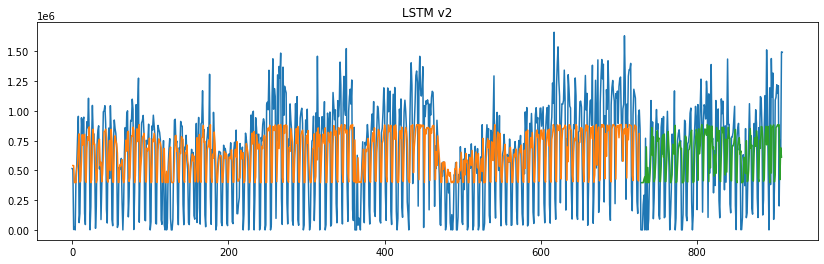

In [45]:
# покажем на графике полученные результаты. Вариант 2
plt.figure(figsize=(14, 4))
 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('LSTM v2')
plt.show()

In [46]:
# создадим и обучим модель LSTM. Вариант 3. Добавим слой Dropout

In [73]:
%%time
model = Sequential()
model.add(LSTM(2, input_shape=(1,look_back)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
726/726 - 1s - loss: 0.0926
Epoch 2/20
726/726 - 0s - loss: 0.0633
Epoch 3/20
726/726 - 0s - loss: 0.0600
Epoch 4/20
726/726 - 0s - loss: 0.0558
Epoch 5/20
726/726 - 0s - loss: 0.0548
Epoch 6/20
726/726 - 0s - loss: 0.0556
Epoch 7/20
726/726 - 0s - loss: 0.0548
Epoch 8/20
726/726 - 0s - loss: 0.0545
Epoch 9/20
726/726 - 0s - loss: 0.0539
Epoch 10/20
726/726 - 0s - loss: 0.0531
Epoch 11/20
726/726 - 0s - loss: 0.0537
Epoch 12/20
726/726 - 0s - loss: 0.0558
Epoch 13/20
726/726 - 0s - loss: 0.0532
Epoch 14/20
726/726 - 0s - loss: 0.0525
Epoch 15/20
726/726 - 0s - loss: 0.0548
Epoch 16/20
726/726 - 0s - loss: 0.0546
Epoch 17/20
726/726 - 0s - loss: 0.0550
Epoch 18/20
726/726 - 0s - loss: 0.0545
Epoch 19/20
726/726 - 0s - loss: 0.0538
Epoch 20/20
726/726 - 0s - loss: 0.0541
Wall time: 8.69 s


In [74]:
# предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# инвертируем предсказания
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
# посчитаем метрику качества
trainScore = np.sqrt(mean_squared_error(scaler.inverse_transform([trainY])[0], trainPredict[:,0]))
print('Train Score v3: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform([testY])[0], testPredict[:,0]))
print('Test Score v3: %.2f RMSE' % (testScore))

Train Score v3: 376043.20 RMSE
Test Score v3: 374321.47 RMSE


In [76]:
# самый оптимальный вариант со слоем Dropout

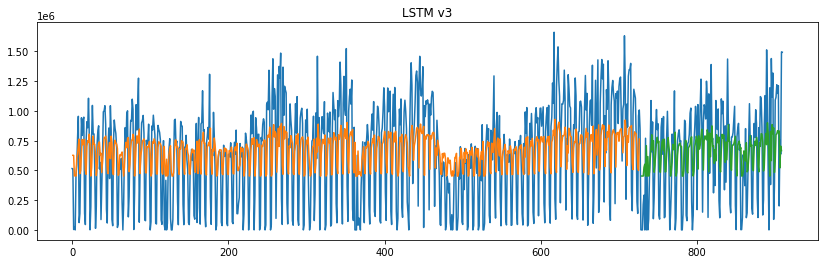

In [75]:
# покажем на графике полученные результаты. Вариант 3
plt.figure(figsize=(14, 4))
 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('LSTM v3')
plt.show()